# 0. Import Library

In [1]:
import torch
import torch.nn.functional as F
import tqdm
import time
import pickle
import matplotlib.pyplot as plt
from replay.replay import ReplayBuffer, BufferFields, set_buffer_dim

# 1. Load Collected Data

In [2]:
device_id = 3
with open('pkl/walker_replay_withterm.pkl', 'rb') as fp:
    replay_buffer = pickle.load(fp)
    
#replay_buffer._buffer['state'][:, 8:] = replay_buffer._buffer['state'][:, 8:]/10
#replay_buffer._buffer['prev_state'][:, 8:] = replay_buffer._buffer['prev_state'][:, 8:]/10
#replay_buffer._buffer['next_state'][:, 8:] = replay_buffer._buffer['next_state'][:, 8:]/10

#for key in BufferFields.keys():
#    print(key)
#    replay_buffer._buffer[key].to(device_id)

print(replay_buffer._buffer.keys())
print(replay_buffer._buffer['state'].size(), replay_buffer._buffer['state'].device)
print(replay_buffer._buffer['action'].size(), replay_buffer._buffer['action'].device)
print(replay_buffer._buffer['reward'].size(), replay_buffer._buffer['reward'].device)
#print(replay_buffer._buffer['prev_state'].size(), replay_buffer._buffer['prev_state'].device)
#print(replay_buffer._buffer['prev_action'].size(), replay_buffer._buffer['prev_action'].device)
set_buffer_dim(17, 6) # walker
#set_buffer_dim(11, 3) # hopper

dict_keys(['state', 'action', 'reward', 'done', 'next_state', 'end'])
torch.Size([1000000, 17]) cuda:3
torch.Size([1000000, 6]) cuda:3
torch.Size([1000000, 1]) cuda:3


# 2. Load Agent

In [3]:
from agent.model_agent import ModelAgent
from agent.disc_agent import DiscriminateAgent

model_agent = ModelAgent(
    device_id,
    trans_hidden_size=[256, 256, 256, 256],
    reward_hidden_size=[256, 256, 256, 256],
    model_activation=torch.nn.LeakyReLU,
    use_batchnorm=False,
    dropout_prob=None,
    deterministic=True)
print(vars(model_agent))

disc_agent = DiscriminateAgent(
    device_id,
    hidden_size=[256, 256, 256, 256],
    activation=torch.nn.LeakyReLU
)
print(vars(disc_agent))

{'_deterministic': False, '_device_id': 3, '_logger': <RootLogger root (WARNING)>, '_transition_mlp': WorldMlp(
  (_model): Sequential(
    (0): Linear(in_features=23, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=256, out_features=256, bias=True)
    (7): LeakyReLU(negative_slope=0.01)
    (8): Linear(in_features=256, out_features=34, bias=True)
  )
), '_reward_mlp': WorldMlp(
  (_model): Sequential(
    (0): Linear(in_features=40, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=256, out_features=256, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=256, out_features=256, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=256, ou

# 3. Setup Data loader and Training Process

In [4]:
#training_range = (0, int(90e3))
training_range = (0, int(100e3))
#validation_range = (int(90e3), int(100e3))
#batch_size = 32
#n_epoch = 5
batch_size = 1024
n_epoch = 160
gan_lr = 1e-4
disc_lr = 1e-4
model_lr = 1e-3
reward_lr = 1e-4
weight_decay = 0

# setup optimizer
#model_params = list(agent.transition_params()) + list(agent.reward_params())
t_optim = torch.optim.AdamW(model_agent.transition_params(), lr=model_lr, weight_decay=weight_decay)
r_optim = torch.optim.AdamW(model_agent.reward_params(), lr=reward_lr, weight_decay=weight_decay)
g_optim = torch.optim.AdamW(model_agent.transition_params(), lr=gan_lr)
d_optim = torch.optim.AdamW(disc_agent.params(), lr=disc_lr)

In [5]:
def range_shuffle_sample(buffer, range_low, range_high):
    shuffled_samples = {}
    range_size = range_high - range_low
    _, indices = torch.rand(range_size).sort()
    for key in buffer.keys():
        range_data = buffer[key][range_low:range_high, :]
        shuffled_samples[key] = range_data[indices,:]    
    return shuffled_samples

buffer = {
    'kkk': torch.tensor([
        [1,2,3],
        [4,5,6],
        [7,8,9],
        [10, 11, 12]
    ]),
    'yyy': torch.tensor([
            [1,2,3],
            [4,5,6],
            [7,8,9],
            [10, 11, 12]
        ])
}
print(range_shuffle_sample(buffer, 0, 4))

t = buffer['kkk']
idx = torch.tensor([
    [1,2,3],
    [1,2,3]])
print(t[idx].shape)

{'kkk': tensor([[ 4,  5,  6],
        [ 1,  2,  3],
        [10, 11, 12],
        [ 7,  8,  9]]), 'yyy': tensor([[ 4,  5,  6],
        [ 1,  2,  3],
        [10, 11, 12],
        [ 7,  8,  9]])}
torch.Size([2, 3, 3])


In [6]:
def train_model(shuffled_samples, model_agent, disc_agent, t_optim, r_optim):
    t_losses = []
    r_losses = []
    g_losses = []
    for it in tqdm.trange(0, int(data_size/batch_size)):
        
        sample = {}
        for key in BufferFields.keys():
            sample[key] = shuffled_samples[key][it*batch_size: (it+1)*batch_size, :]

        next_state_diff = model_agent.transition(sample['state'], sample['action'])
        next_state_pred = sample['state'] + next_state_diff
        reward_pred = model_agent.reward(sample['state'], sample['action'], next_state_pred.detach())

        transition_reg_loss = F.mse_loss(next_state_pred, sample['next_state'])
        reward_reg_loss = F.mse_loss(reward_pred, sample['reward'])
        t_losses.append(transition_reg_loss)
        r_losses.append(reward_reg_loss)
        
        # gan loss
        next_state_diff = model_agent.transition(sample['state'], torch.rand_like(sample['action']) * 2 - 1)
        logits, pred = disc_agent.discriminate(sample['state'], next_state_diff)
        true_labels = torch.full((batch_size, 1), .9, dtype=logits.dtype, device=logits.device)
        gan_loss = 0.0 * F.binary_cross_entropy_with_logits(logits, true_labels)
        g_losses.append(gan_loss)
        
        #total_loss = transition_reg_loss + reward_reg_loss #+ 0.0 * gan_loss
        #total_loss = gan_loss
        #losses['total'].append(total_loss)

        t_optim.zero_grad()
        r_optim.zero_grad()

        transition_reg_loss.backward()
        reward_reg_loss.backward()
        gan_loss.backward()
        #gan_loss.backward()
        #total_loss.backward()

        t_optim.step()
        r_optim.step()
        
    return t_losses, r_losses, g_losses


In [7]:
def train_disc(shuffled_samples, model_agent, disc_agent, d_optim):
    errors = []
    losses = []
    for it in tqdm.trange(0, int(data_size/batch_size)):
        # get a batch of data
        #real_samples = replay_buffer.range_sample(batch_size, training_range[0], training_range[1], device_id)
        real_samples = {}
        for key in BufferFields.keys():
            real_samples[key] = shuffled_samples[key][it*batch_size: (it+1)*batch_size, :]
        
        # get predict
        #next_state_diff = model_agent.transition(real_samples['state'], real_samples['action'] + torch.randn_like(real_samples['action'])/10.0)
        next_state_diff = model_agent.transition(real_samples['state'], torch.rand_like(real_samples['action']) * 2 - 1)
        next_state_pred = real_samples['state'] + next_state_diff
         
        samples = {}
        samples['state'] = torch.cat((real_samples['state'], real_samples['state']), dim=0)
        #samples['next_state'] = torch.cat((real_samples['next_state'], next_state_pred.detach()), dim=0) 
        samples['next_state'] = torch.cat((real_samples['next_state'] - real_samples['state'], next_state_diff.detach()), dim=0) 

        # soft labels    
        #true_labels = torch.full((batch_size,), .8) + torch.randn((batch_size,))/10.0    
        #fake_labels = torch.full((batch_size,), .2) + torch.randn((batch_size,))/10.0
        true_labels = torch.full((batch_size,), .9)
        fake_labels = torch.full((batch_size,), .1)
        labels = torch.cat((true_labels, fake_labels)).view(-1,1).to(device_id)    

            
        logits, pred = disc_agent.discriminate(    
              samples['state'].detach(),     
              samples['next_state'].detach())
        
        error = (pred-labels).abs().sum()/(2*batch_size)    
        loss = F.binary_cross_entropy_with_logits(logits, labels)
        errors.append(error)    
        losses.append(loss)
        
        d_optim.zero_grad()
        loss.backward()
        d_optim.step()

    return errors, losses

In [8]:
def gan_model(shuffled_samples, model_agent, disc_agent, gan_optim):
    losses = []
    for it in tqdm.trange(0, int(data_size/batch_size)):
        
        # get a batch of data
        sample = {}
        for key in BufferFields.keys():
            sample[key] = shuffled_samples[key][it*batch_size: (it+1)*batch_size, :]
            
        #next_state_diff = model_agent.transition(sample['state'], sample['action'] + torch.randn_like(sample['action'])/10.0)
        next_state_diff = model_agent.transition(sample['state'], torch.rand_like(sample['action']) * 2 - 1)
        next_state_pred = sample['state'] + next_state_diff
        #reward_pred = model_agent.reward(sample['state'], sample['action'], next_state_pred.detach())
        
        # gan loss
        #logits, pred = disc_agent.discriminate(sample['state'], next_state_pred)
        logits, pred = disc_agent.discriminate(sample['state'], next_state_diff)
        #true_labels = torch.full((batch_size, 1), .8, dtype=logits.dtype, device=logits.device) + torch.randn((batch_size, 1), dtype=logits.dtype, device=logits.device)/10.0 
        true_labels = torch.full((batch_size, 1), .9, dtype=logits.dtype, device=logits.device)
        gan_loss = F.binary_cross_entropy_with_logits(logits, true_labels)
        
        losses.append(gan_loss)
        
        g_optim.zero_grad()
        gan_loss.backward()
        g_optim.step()
    
    return losses


In [9]:
def plot_losses(losses):

    def subplot_setting(ax):
        ax.legend()
        ax.set_ylabel('Values')
        ax.set_xlabel('Iterations')

    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(30,10))
    ax[0][0].plot(losses['transition'], label='transition loss')
    ax[0][1].plot(losses['reward'], label='reward loss')
    ax[0][2].plot(losses['gan'], label='gan loss')
    ax[1][0].plot(losses['total'], label='total loss')
    ax[1][1].plot(losses['disc'], label='disc loss')
    ax[1][2].plot(losses['disc_errors'], label='disc_errors')

    subplot_setting(ax[0][0])
    subplot_setting(ax[0][1])
    subplot_setting(ax[0][2])
    subplot_setting(ax[1][0])
    subplot_setting(ax[1][1])
    subplot_setting(ax[1][2])

    plt.show()

  0%|          | 0/97 [00:00<?, ?it/s]

data_size: 100000
epoch: 0


  6%|▌         | 6/97 [00:00<00:01, 47.17it/s]

disc_losses: tensor(0.5094, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 10%|█         | 10/97 [00:00<00:00, 96.10it/s]

transition_losses: tensor(1.8327, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 1


  6%|▌         | 6/97 [00:00<00:01, 51.19it/s]

disc_losses: tensor(0.5065, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 10%|█         | 10/97 [00:00<00:00, 95.70it/s]

transition_losses: tensor(1.5524, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 2


  4%|▍         | 4/97 [00:00<00:02, 33.39it/s]

disc_losses: tensor(0.4935, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 10%|█         | 10/97 [00:00<00:00, 95.42it/s]

transition_losses: tensor(1.3791, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 3


  5%|▌         | 5/97 [00:00<00:01, 48.60it/s]

disc_losses: tensor(0.4661, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


  8%|▊         | 8/97 [00:00<00:01, 73.36it/s]

transition_losses: tensor(1.2732, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 4


  5%|▌         | 5/97 [00:00<00:02, 37.68it/s]

disc_losses: tensor(0.4691, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


  9%|▉         | 9/97 [00:00<00:01, 86.30it/s]

transition_losses: tensor(1.2479, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 5


  5%|▌         | 5/97 [00:00<00:02, 45.97it/s]

disc_losses: tensor(0.4814, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


  7%|▋         | 7/97 [00:00<00:01, 67.58it/s]

transition_losses: tensor(1.1521, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 6


  5%|▌         | 5/97 [00:00<00:01, 46.45it/s]

disc_losses: tensor(0.4806, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 10%|█         | 10/97 [00:00<00:00, 89.80it/s]

transition_losses: tensor(1.1663, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 7


  8%|▊         | 8/97 [00:00<00:01, 71.86it/s]

disc_losses: tensor(0.4594, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


  9%|▉         | 9/97 [00:00<00:00, 89.04it/s]

transition_losses: tensor(0.9634, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 8


  4%|▍         | 4/97 [00:00<00:02, 39.35it/s]

disc_losses: tensor(0.4551, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 10%|█         | 10/97 [00:00<00:00, 98.74it/s]

transition_losses: tensor(1.0009, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 9


  8%|▊         | 8/97 [00:00<00:01, 72.33it/s]

disc_losses: tensor(0.4575, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 16%|█▋        | 16/97 [00:00<00:00, 152.02it/s]

transition_losses: tensor(0.9333, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 10


  8%|▊         | 8/97 [00:00<00:01, 73.17it/s]

disc_losses: tensor(0.4588, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 11%|█▏        | 11/97 [00:00<00:00, 101.97it/s]

transition_losses: tensor(1.0126, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 11


  6%|▌         | 6/97 [00:00<00:01, 49.38it/s]

disc_losses: tensor(0.4732, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 10%|█         | 10/97 [00:00<00:00, 93.82it/s]

transition_losses: tensor(0.8917, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 12


  6%|▌         | 6/97 [00:00<00:01, 58.68it/s]

disc_losses: tensor(0.4656, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


  7%|▋         | 7/97 [00:00<00:01, 69.95it/s]

transition_losses: tensor(0.7571, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 13


  5%|▌         | 5/97 [00:00<00:02, 44.58it/s]

disc_losses: tensor(0.4501, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 11%|█▏        | 11/97 [00:00<00:00, 108.84it/s]

transition_losses: tensor(0.7516, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 14


  5%|▌         | 5/97 [00:00<00:02, 42.79it/s]

disc_losses: tensor(0.4487, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


  9%|▉         | 9/97 [00:00<00:01, 87.96it/s]

transition_losses: tensor(0.7839, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 15


  5%|▌         | 5/97 [00:00<00:01, 49.63it/s]

disc_losses: tensor(0.4810, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


  9%|▉         | 9/97 [00:00<00:01, 86.80it/s]

transition_losses: tensor(0.7412, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 16


  4%|▍         | 4/97 [00:00<00:02, 38.64it/s]

disc_losses: tensor(0.4555, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 11%|█▏        | 11/97 [00:00<00:00, 101.42it/s]

transition_losses: tensor(0.6529, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 17


  4%|▍         | 4/97 [00:00<00:02, 37.29it/s]

disc_losses: tensor(0.4665, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


  9%|▉         | 9/97 [00:00<00:01, 81.74it/s]

transition_losses: tensor(0.6550, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 18


  8%|▊         | 8/97 [00:00<00:01, 73.97it/s]

disc_losses: tensor(0.4690, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


  8%|▊         | 8/97 [00:00<00:01, 79.61it/s]

transition_losses: tensor(0.6931, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 19


  7%|▋         | 7/97 [00:00<00:01, 66.07it/s]

disc_losses: tensor(0.4561, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


  7%|▋         | 7/97 [00:00<00:01, 64.59it/s]

transition_losses: tensor(0.6163, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 20


  5%|▌         | 5/97 [00:00<00:01, 47.67it/s]

disc_losses: tensor(0.4601, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


  7%|▋         | 7/97 [00:00<00:01, 69.69it/s]

transition_losses: tensor(0.5838, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 21


  4%|▍         | 4/97 [00:00<00:02, 39.80it/s]

disc_losses: tensor(0.4730, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


  8%|▊         | 8/97 [00:00<00:01, 73.29it/s]

transition_losses: tensor(0.5802, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 22


  7%|▋         | 7/97 [00:00<00:01, 61.86it/s]

disc_losses: tensor(0.4680, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 12%|█▏        | 12/97 [00:00<00:00, 114.77it/s]

transition_losses: tensor(0.5506, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 23


  7%|▋         | 7/97 [00:00<00:01, 60.96it/s]

disc_losses: tensor(0.4548, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


  8%|▊         | 8/97 [00:00<00:01, 73.90it/s]

transition_losses: tensor(0.5326, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 24


  5%|▌         | 5/97 [00:00<00:02, 41.66it/s]

disc_losses: tensor(0.4608, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 11%|█▏        | 11/97 [00:00<00:00, 102.91it/s]

transition_losses: tensor(0.4814, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 25


  8%|▊         | 8/97 [00:00<00:01, 73.67it/s]

disc_losses: tensor(0.4655, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 14%|█▍        | 14/97 [00:00<00:00, 132.58it/s]

transition_losses: tensor(0.4886, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 26


  5%|▌         | 5/97 [00:00<00:01, 49.32it/s]

disc_losses: tensor(0.4628, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 10%|█         | 10/97 [00:00<00:00, 93.86it/s]

transition_losses: tensor(0.4598, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 27


  6%|▌         | 6/97 [00:00<00:01, 56.63it/s]

disc_losses: tensor(0.4678, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 10%|█         | 10/97 [00:00<00:00, 92.73it/s]

transition_losses: tensor(0.4248, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 28


  8%|▊         | 8/97 [00:00<00:01, 71.61it/s]

disc_losses: tensor(0.4773, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 12%|█▏        | 12/97 [00:00<00:00, 108.58it/s]

transition_losses: tensor(0.4371, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 29


  6%|▌         | 6/97 [00:00<00:01, 54.52it/s]

disc_losses: tensor(0.4705, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 10%|█         | 10/97 [00:00<00:00, 99.05it/s]

transition_losses: tensor(0.4271, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 30


  8%|▊         | 8/97 [00:00<00:01, 73.43it/s]

disc_losses: tensor(0.4663, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 10%|█         | 10/97 [00:00<00:00, 94.43it/s]

transition_losses: tensor(0.4128, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 31


  7%|▋         | 7/97 [00:00<00:01, 66.81it/s]

disc_losses: tensor(0.4744, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 10%|█         | 10/97 [00:00<00:00, 96.74it/s]

transition_losses: tensor(0.4507, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 32


  5%|▌         | 5/97 [00:00<00:01, 46.36it/s]

disc_losses: tensor(0.4663, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 12%|█▏        | 12/97 [00:00<00:00, 114.30it/s]

transition_losses: tensor(0.3927, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 33


  6%|▌         | 6/97 [00:00<00:01, 57.04it/s]

disc_losses: tensor(0.4649, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 14%|█▍        | 14/97 [00:00<00:00, 135.50it/s]

transition_losses: tensor(0.4258, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 34


  7%|▋         | 7/97 [00:00<00:01, 67.72it/s]

disc_losses: tensor(0.4619, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


  7%|▋         | 7/97 [00:00<00:01, 66.01it/s]

transition_losses: tensor(0.3463, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 35


  6%|▌         | 6/97 [00:00<00:01, 53.03it/s]

disc_losses: tensor(0.4704, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


  9%|▉         | 9/97 [00:00<00:01, 77.94it/s]

transition_losses: tensor(0.3722, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 36


  5%|▌         | 5/97 [00:00<00:02, 43.71it/s]

disc_losses: tensor(0.4651, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


  7%|▋         | 7/97 [00:00<00:01, 68.00it/s]

transition_losses: tensor(0.3372, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 37


  5%|▌         | 5/97 [00:00<00:01, 48.58it/s]

disc_losses: tensor(0.4662, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 10%|█         | 10/97 [00:00<00:00, 91.21it/s]

transition_losses: tensor(0.3707, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 38


  8%|▊         | 8/97 [00:00<00:01, 74.86it/s]

disc_losses: tensor(0.4521, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


  6%|▌         | 6/97 [00:00<00:01, 52.86it/s]

transition_losses: tensor(0.4150, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 39


  4%|▍         | 4/97 [00:00<00:02, 37.48it/s]

disc_losses: tensor(0.4568, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


  5%|▌         | 5/97 [00:00<00:02, 39.62it/s]

transition_losses: tensor(0.3104, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 40


  5%|▌         | 5/97 [00:00<00:02, 43.54it/s]

disc_losses: tensor(0.4561, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 10%|█         | 10/97 [00:00<00:00, 92.85it/s]

transition_losses: tensor(0.3303, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 41


  7%|▋         | 7/97 [00:00<00:01, 69.75it/s]

disc_losses: tensor(0.4652, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


  7%|▋         | 7/97 [00:00<00:01, 66.38it/s]

transition_losses: tensor(0.3341, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 42


  5%|▌         | 5/97 [00:00<00:02, 43.63it/s]

disc_losses: tensor(0.4489, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


  9%|▉         | 9/97 [00:00<00:01, 86.64it/s]

transition_losses: tensor(0.3087, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 43


  6%|▌         | 6/97 [00:00<00:01, 53.35it/s]

disc_losses: tensor(0.4390, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


  9%|▉         | 9/97 [00:00<00:00, 88.08it/s]

transition_losses: tensor(0.3271, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 44


  6%|▌         | 6/97 [00:00<00:01, 54.24it/s]

disc_losses: tensor(0.4532, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 20%|█▉        | 19/97 [00:00<00:00, 184.35it/s]

transition_losses: tensor(0.2889, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 45


  8%|▊         | 8/97 [00:00<00:01, 72.06it/s]

disc_losses: tensor(0.4564, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 11%|█▏        | 11/97 [00:00<00:00, 103.63it/s]

transition_losses: tensor(0.3319, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 46


  7%|▋         | 7/97 [00:00<00:01, 65.09it/s]

disc_losses: tensor(0.4560, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 15%|█▌        | 15/97 [00:00<00:00, 146.48it/s]

transition_losses: tensor(0.3122, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 47


  7%|▋         | 7/97 [00:00<00:01, 69.84it/s]

disc_losses: tensor(0.4724, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 15%|█▌        | 15/97 [00:00<00:00, 144.06it/s]

transition_losses: tensor(0.3211, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 48


  7%|▋         | 7/97 [00:00<00:01, 61.74it/s]

disc_losses: tensor(0.4687, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 12%|█▏        | 12/97 [00:00<00:00, 110.94it/s]

transition_losses: tensor(0.2731, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 49


  7%|▋         | 7/97 [00:00<00:01, 64.13it/s]

disc_losses: tensor(0.4618, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 16%|█▋        | 16/97 [00:00<00:00, 153.26it/s]

transition_losses: tensor(0.3092, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 50


  7%|▋         | 7/97 [00:00<00:01, 62.71it/s]

disc_losses: tensor(0.4548, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 12%|█▏        | 12/97 [00:00<00:00, 113.95it/s]

transition_losses: tensor(0.2817, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 51


  5%|▌         | 5/97 [00:00<00:01, 48.57it/s]

disc_losses: tensor(0.4643, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 14%|█▍        | 14/97 [00:00<00:00, 133.46it/s]

transition_losses: tensor(0.2816, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 52


  7%|▋         | 7/97 [00:00<00:01, 64.16it/s]

disc_losses: tensor(0.4552, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 12%|█▏        | 12/97 [00:00<00:00, 113.30it/s]

transition_losses: tensor(0.2641, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 53


  8%|▊         | 8/97 [00:00<00:01, 70.94it/s]

disc_losses: tensor(0.4623, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 10%|█         | 10/97 [00:00<00:00, 90.74it/s]

transition_losses: tensor(0.3051, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 54


  6%|▌         | 6/97 [00:00<00:01, 57.67it/s]

disc_losses: tensor(0.4491, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


  9%|▉         | 9/97 [00:00<00:01, 85.60it/s]

transition_losses: tensor(0.2609, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 55


  6%|▌         | 6/97 [00:00<00:01, 59.87it/s]

disc_losses: tensor(0.4471, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 10%|█         | 10/97 [00:00<00:01, 77.74it/s]

transition_losses: tensor(0.2646, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 56


  7%|▋         | 7/97 [00:00<00:01, 65.01it/s]

disc_losses: tensor(0.4493, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


  0%|          | 0/97 [00:00<?, ?it/s]

transition_losses: tensor(0.2521, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 57


  7%|▋         | 7/97 [00:00<00:01, 67.21it/s]

disc_losses: tensor(0.4518, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


  4%|▍         | 4/97 [00:00<00:02, 39.04it/s]

transition_losses: tensor(0.2551, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 58


  6%|▌         | 6/97 [00:00<00:01, 56.31it/s]

disc_losses: tensor(0.4499, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


  9%|▉         | 9/97 [00:00<00:01, 87.50it/s]

transition_losses: tensor(0.2385, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 59


  7%|▋         | 7/97 [00:00<00:01, 62.72it/s]

disc_losses: tensor(0.4582, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 10%|█         | 10/97 [00:00<00:00, 97.66it/s]

transition_losses: tensor(0.2530, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 60


  6%|▌         | 6/97 [00:00<00:01, 51.21it/s]

disc_losses: tensor(0.4437, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


  8%|▊         | 8/97 [00:00<00:01, 72.38it/s]

transition_losses: tensor(0.2681, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 61


  5%|▌         | 5/97 [00:00<00:01, 50.00it/s]

disc_losses: tensor(0.4556, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


  9%|▉         | 9/97 [00:00<00:01, 76.62it/s]

transition_losses: tensor(0.2319, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 62


  3%|▎         | 3/97 [00:00<00:03, 29.69it/s]

disc_losses: tensor(0.4619, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 12%|█▏        | 12/97 [00:00<00:00, 118.12it/s]

transition_losses: tensor(0.2568, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 63


  5%|▌         | 5/97 [00:00<00:01, 49.84it/s]

disc_losses: tensor(0.4492, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 11%|█▏        | 11/97 [00:00<00:00, 105.30it/s]

transition_losses: tensor(0.2673, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 64


  3%|▎         | 3/97 [00:00<00:04, 20.41it/s]

disc_losses: tensor(0.4492, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 13%|█▎        | 13/97 [00:00<00:00, 127.29it/s]

transition_losses: tensor(0.2589, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 65


  7%|▋         | 7/97 [00:00<00:01, 64.06it/s]

disc_losses: tensor(0.4455, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


  7%|▋         | 7/97 [00:00<00:01, 65.73it/s]

transition_losses: tensor(0.2390, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 66


  5%|▌         | 5/97 [00:00<00:02, 41.12it/s]

disc_losses: tensor(0.4581, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 12%|█▏        | 12/97 [00:00<00:00, 98.20it/s]

transition_losses: tensor(0.2282, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 67


  5%|▌         | 5/97 [00:00<00:01, 48.88it/s]

disc_losses: tensor(0.4579, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


  7%|▋         | 7/97 [00:00<00:01, 67.55it/s]

transition_losses: tensor(0.2462, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 68


  8%|▊         | 8/97 [00:00<00:01, 72.15it/s]

disc_losses: tensor(0.4407, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


  8%|▊         | 8/97 [00:00<00:01, 77.19it/s]

transition_losses: tensor(0.2409, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 69


  6%|▌         | 6/97 [00:00<00:01, 54.84it/s]

disc_losses: tensor(0.4512, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 14%|█▍        | 14/97 [00:00<00:00, 134.54it/s]

transition_losses: tensor(0.2191, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 70


  7%|▋         | 7/97 [00:00<00:01, 64.12it/s]

disc_losses: tensor(0.4584, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 12%|█▏        | 12/97 [00:00<00:00, 119.80it/s]

transition_losses: tensor(0.2302, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 71


  5%|▌         | 5/97 [00:00<00:01, 49.31it/s]

disc_losses: tensor(0.4580, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 15%|█▌        | 15/97 [00:00<00:00, 144.58it/s]

transition_losses: tensor(0.2345, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 72


  7%|▋         | 7/97 [00:00<00:01, 69.91it/s]

disc_losses: tensor(0.4471, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 10%|█         | 10/97 [00:00<00:00, 96.05it/s]

transition_losses: tensor(0.2252, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 73


  6%|▌         | 6/97 [00:00<00:01, 59.86it/s]

disc_losses: tensor(0.4455, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


  9%|▉         | 9/97 [00:00<00:00, 88.27it/s]

transition_losses: tensor(0.2237, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 74


  6%|▌         | 6/97 [00:00<00:01, 57.41it/s]

disc_losses: tensor(0.4405, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


  9%|▉         | 9/97 [00:00<00:01, 86.19it/s]

transition_losses: tensor(0.1945, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 75


  4%|▍         | 4/97 [00:00<00:02, 36.70it/s]

disc_losses: tensor(0.4539, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 11%|█▏        | 11/97 [00:00<00:00, 99.05it/s]

transition_losses: tensor(0.1920, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 76


  5%|▌         | 5/97 [00:00<00:02, 44.36it/s]

disc_losses: tensor(0.4477, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


  8%|▊         | 8/97 [00:00<00:01, 71.02it/s]

transition_losses: tensor(0.2130, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 77


  8%|▊         | 8/97 [00:00<00:01, 67.99it/s]

disc_losses: tensor(0.4651, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 14%|█▍        | 14/97 [00:00<00:00, 137.75it/s]

transition_losses: tensor(0.2255, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 78


  6%|▌         | 6/97 [00:00<00:01, 58.26it/s]

disc_losses: tensor(0.4607, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


  9%|▉         | 9/97 [00:00<00:00, 88.68it/s]

transition_losses: tensor(0.1967, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 79


  7%|▋         | 7/97 [00:00<00:01, 63.15it/s]

disc_losses: tensor(0.4588, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 13%|█▎        | 13/97 [00:00<00:00, 116.52it/s]

transition_losses: tensor(0.2084, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 80


  6%|▌         | 6/97 [00:00<00:01, 58.92it/s]

disc_losses: tensor(0.4483, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 15%|█▌        | 15/97 [00:00<00:00, 143.31it/s]

transition_losses: tensor(0.1979, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 81


  7%|▋         | 7/97 [00:00<00:01, 67.63it/s]

disc_losses: tensor(0.4456, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 14%|█▍        | 14/97 [00:00<00:00, 136.26it/s]

transition_losses: tensor(0.1932, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 82


  5%|▌         | 5/97 [00:00<00:02, 37.83it/s]

disc_losses: tensor(0.4470, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 13%|█▎        | 13/97 [00:00<00:00, 129.94it/s]

transition_losses: tensor(0.1872, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 83


  8%|▊         | 8/97 [00:00<00:01, 73.05it/s]

disc_losses: tensor(0.4475, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


  9%|▉         | 9/97 [00:00<00:01, 83.74it/s]

transition_losses: tensor(0.1826, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 84


  5%|▌         | 5/97 [00:00<00:02, 45.81it/s]

disc_losses: tensor(0.4593, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


  9%|▉         | 9/97 [00:00<00:01, 84.98it/s]

transition_losses: tensor(0.1840, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 85


  4%|▍         | 4/97 [00:00<00:02, 34.14it/s]

disc_losses: tensor(0.4589, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 11%|█▏        | 11/97 [00:00<00:00, 105.59it/s]

transition_losses: tensor(0.1934, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 86


  6%|▌         | 6/97 [00:00<00:01, 54.21it/s]

disc_losses: tensor(0.4629, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 12%|█▏        | 12/97 [00:00<00:00, 117.98it/s]

transition_losses: tensor(0.1738, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 87


  4%|▍         | 4/97 [00:00<00:02, 37.00it/s]

disc_losses: tensor(0.4516, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 12%|█▏        | 12/97 [00:00<00:00, 113.73it/s]

transition_losses: tensor(0.1878, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 88


  5%|▌         | 5/97 [00:00<00:02, 43.30it/s]

disc_losses: tensor(0.4418, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 10%|█         | 10/97 [00:00<00:00, 92.11it/s]

transition_losses: tensor(0.1694, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 89


  5%|▌         | 5/97 [00:00<00:02, 38.71it/s]

disc_losses: tensor(0.4551, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 11%|█▏        | 11/97 [00:00<00:00, 109.55it/s]

transition_losses: tensor(0.1677, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 90


  5%|▌         | 5/97 [00:00<00:02, 44.11it/s]

disc_losses: tensor(0.4464, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


  8%|▊         | 8/97 [00:00<00:01, 74.23it/s]

transition_losses: tensor(0.1563, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 91


  6%|▌         | 6/97 [00:00<00:01, 52.46it/s]

disc_losses: tensor(0.4471, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 10%|█         | 10/97 [00:00<00:00, 92.11it/s]

transition_losses: tensor(0.1632, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 92


  4%|▍         | 4/97 [00:00<00:02, 37.69it/s]

disc_losses: tensor(0.4414, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 11%|█▏        | 11/97 [00:00<00:00, 104.90it/s]

transition_losses: tensor(0.1914, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 93


  8%|▊         | 8/97 [00:00<00:01, 73.17it/s]

disc_losses: tensor(0.4402, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 10%|█         | 10/97 [00:00<00:00, 97.00it/s]

transition_losses: tensor(0.1741, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 94


  6%|▌         | 6/97 [00:00<00:01, 59.06it/s]

disc_losses: tensor(0.4333, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


  9%|▉         | 9/97 [00:00<00:01, 86.14it/s]

transition_losses: tensor(0.1712, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 95


  6%|▌         | 6/97 [00:00<00:01, 58.41it/s]

disc_losses: tensor(0.4504, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


  9%|▉         | 9/97 [00:00<00:01, 80.74it/s]

transition_losses: tensor(0.1631, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 96


  3%|▎         | 3/97 [00:00<00:03, 24.45it/s]

disc_losses: tensor(0.4407, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


  7%|▋         | 7/97 [00:00<00:01, 62.85it/s]

transition_losses: tensor(0.1732, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 97


  4%|▍         | 4/97 [00:00<00:02, 35.06it/s]

disc_losses: tensor(0.4535, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 10%|█         | 10/97 [00:00<00:00, 93.39it/s]

transition_losses: tensor(0.1732, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 98


  5%|▌         | 5/97 [00:00<00:01, 48.02it/s]

disc_losses: tensor(0.4442, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 11%|█▏        | 11/97 [00:00<00:00, 107.99it/s]

transition_losses: tensor(0.1714, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 99


  6%|▌         | 6/97 [00:00<00:01, 54.28it/s]

disc_losses: tensor(0.4452, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 11%|█▏        | 11/97 [00:00<00:00, 106.81it/s]

transition_losses: tensor(0.1515, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 100


  6%|▌         | 6/97 [00:00<00:01, 55.50it/s]

disc_losses: tensor(0.4497, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


  9%|▉         | 9/97 [00:00<00:01, 81.11it/s]

transition_losses: tensor(0.1571, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 101


  4%|▍         | 4/97 [00:00<00:02, 35.19it/s]

disc_losses: tensor(0.4393, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


  9%|▉         | 9/97 [00:00<00:00, 89.66it/s]

transition_losses: tensor(0.1571, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 102


  5%|▌         | 5/97 [00:00<00:02, 45.73it/s]

disc_losses: tensor(0.4430, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 10%|█         | 10/97 [00:00<00:00, 97.51it/s]

transition_losses: tensor(0.1766, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 103


  5%|▌         | 5/97 [00:00<00:01, 49.13it/s]

disc_losses: tensor(0.4464, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


  3%|▎         | 3/97 [00:00<00:03, 29.53it/s]

transition_losses: tensor(0.1727, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 104


  5%|▌         | 5/97 [00:00<00:01, 46.65it/s]

disc_losses: tensor(0.4478, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 13%|█▎        | 13/97 [00:00<00:00, 124.15it/s]

transition_losses: tensor(0.1498, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 105


  6%|▌         | 6/97 [00:00<00:01, 58.18it/s]

disc_losses: tensor(0.4588, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


  7%|▋         | 7/97 [00:00<00:01, 66.36it/s]

transition_losses: tensor(0.1599, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 106


  6%|▌         | 6/97 [00:00<00:01, 54.78it/s]

disc_losses: tensor(0.4391, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


  8%|▊         | 8/97 [00:00<00:01, 78.34it/s]

transition_losses: tensor(0.1334, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 107


  6%|▌         | 6/97 [00:00<00:01, 59.27it/s]

disc_losses: tensor(0.4291, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


  0%|          | 0/97 [00:00<?, ?it/s]

transition_losses: tensor(0.1529, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 108


  6%|▌         | 6/97 [00:00<00:01, 50.04it/s]

disc_losses: tensor(0.4469, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


  6%|▌         | 6/97 [00:00<00:01, 53.40it/s]

transition_losses: tensor(0.1232, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 109


  5%|▌         | 5/97 [00:00<00:02, 45.98it/s]

disc_losses: tensor(0.4418, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


  9%|▉         | 9/97 [00:00<00:01, 87.73it/s]

transition_losses: tensor(0.1427, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 110


  4%|▍         | 4/97 [00:00<00:02, 39.52it/s]

disc_losses: tensor(0.4492, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


  7%|▋         | 7/97 [00:00<00:01, 66.96it/s]

transition_losses: tensor(0.1485, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 111


  3%|▎         | 3/97 [00:00<00:03, 26.76it/s]

disc_losses: tensor(0.4501, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 12%|█▏        | 12/97 [00:00<00:00, 117.01it/s]

transition_losses: tensor(0.1555, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 112


  4%|▍         | 4/97 [00:00<00:02, 34.35it/s]

disc_losses: tensor(0.4319, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 16%|█▋        | 16/97 [00:00<00:00, 159.53it/s]

transition_losses: tensor(0.1723, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 113


  7%|▋         | 7/97 [00:00<00:01, 68.57it/s]

disc_losses: tensor(0.4443, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


  5%|▌         | 5/97 [00:00<00:01, 48.01it/s]

transition_losses: tensor(0.1438, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 114


  6%|▌         | 6/97 [00:00<00:01, 55.50it/s]

disc_losses: tensor(0.4436, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


  8%|▊         | 8/97 [00:00<00:01, 77.40it/s]

transition_losses: tensor(0.1567, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 115


  8%|▊         | 8/97 [00:00<00:01, 74.16it/s]

disc_losses: tensor(0.4492, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


  9%|▉         | 9/97 [00:00<00:00, 88.29it/s]

transition_losses: tensor(0.1489, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 116


  5%|▌         | 5/97 [00:00<00:01, 47.54it/s]

disc_losses: tensor(0.4465, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 15%|█▌        | 15/97 [00:00<00:00, 141.73it/s]

transition_losses: tensor(0.1260, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 117


  8%|▊         | 8/97 [00:00<00:01, 74.64it/s]

disc_losses: tensor(0.4389, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 16%|█▋        | 16/97 [00:00<00:00, 152.41it/s]

transition_losses: tensor(0.1456, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 118


  7%|▋         | 7/97 [00:00<00:01, 61.49it/s]

disc_losses: tensor(0.4370, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


  8%|▊         | 8/97 [00:00<00:01, 75.84it/s]

transition_losses: tensor(0.1405, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 119


  4%|▍         | 4/97 [00:00<00:02, 36.95it/s]

disc_losses: tensor(0.4422, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 12%|█▏        | 12/97 [00:00<00:00, 117.01it/s]

transition_losses: tensor(0.1414, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 120


  6%|▌         | 6/97 [00:00<00:01, 57.78it/s]

disc_losses: tensor(0.4440, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 10%|█         | 10/97 [00:00<00:00, 94.96it/s]

transition_losses: tensor(0.1410, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 121


  4%|▍         | 4/97 [00:00<00:02, 32.78it/s]

disc_losses: tensor(0.4344, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 10%|█         | 10/97 [00:00<00:00, 93.61it/s]

transition_losses: tensor(0.1178, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 122


  6%|▌         | 6/97 [00:00<00:01, 52.77it/s]

disc_losses: tensor(0.4418, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 10%|█         | 10/97 [00:00<00:00, 97.62it/s]

transition_losses: tensor(0.1416, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 123


  6%|▌         | 6/97 [00:00<00:01, 57.27it/s]

disc_losses: tensor(0.4406, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 15%|█▌        | 15/97 [00:00<00:00, 143.34it/s]

transition_losses: tensor(0.1290, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 124


  7%|▋         | 7/97 [00:00<00:01, 66.64it/s]

disc_losses: tensor(0.4412, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 16%|█▋        | 16/97 [00:00<00:00, 150.12it/s]

transition_losses: tensor(0.1319, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 125


  6%|▌         | 6/97 [00:00<00:01, 52.59it/s]

disc_losses: tensor(0.4227, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 11%|█▏        | 11/97 [00:00<00:00, 103.46it/s]

transition_losses: tensor(0.1362, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 126


  5%|▌         | 5/97 [00:00<00:01, 46.23it/s]

disc_losses: tensor(0.4357, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


  8%|▊         | 8/97 [00:00<00:01, 76.73it/s]

transition_losses: tensor(0.1430, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 127


  4%|▍         | 4/97 [00:00<00:02, 37.81it/s]

disc_losses: tensor(0.4465, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 15%|█▌        | 15/97 [00:00<00:00, 141.84it/s]

transition_losses: tensor(0.1253, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 128


  7%|▋         | 7/97 [00:00<00:01, 67.24it/s]

disc_losses: tensor(0.4360, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 12%|█▏        | 12/97 [00:00<00:00, 118.57it/s]

transition_losses: tensor(0.1219, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 129


  5%|▌         | 5/97 [00:00<00:02, 40.67it/s]

disc_losses: tensor(0.4446, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 13%|█▎        | 13/97 [00:00<00:00, 117.55it/s]

transition_losses: tensor(0.1363, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 130


  8%|▊         | 8/97 [00:00<00:01, 61.34it/s]

disc_losses: tensor(0.4419, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 15%|█▌        | 15/97 [00:00<00:00, 148.58it/s]

transition_losses: tensor(0.1144, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 131


  5%|▌         | 5/97 [00:00<00:01, 46.82it/s]

disc_losses: tensor(0.4378, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 14%|█▍        | 14/97 [00:00<00:00, 139.42it/s]

transition_losses: tensor(0.1319, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 132


  6%|▌         | 6/97 [00:00<00:01, 53.30it/s]

disc_losses: tensor(0.4454, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 13%|█▎        | 13/97 [00:00<00:00, 129.66it/s]

transition_losses: tensor(0.1204, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 133


  7%|▋         | 7/97 [00:00<00:01, 66.31it/s]

disc_losses: tensor(0.4434, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 16%|█▋        | 16/97 [00:00<00:00, 155.24it/s]

transition_losses: tensor(0.1231, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 134


  8%|▊         | 8/97 [00:00<00:01, 77.78it/s]

disc_losses: tensor(0.4362, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 18%|█▊        | 17/97 [00:00<00:00, 164.43it/s]

transition_losses: tensor(0.1244, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 135


  8%|▊         | 8/97 [00:00<00:01, 71.63it/s]

disc_losses: tensor(0.4393, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 18%|█▊        | 17/97 [00:00<00:00, 169.03it/s]

transition_losses: tensor(0.1405, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 136


  8%|▊         | 8/97 [00:00<00:01, 73.45it/s]

disc_losses: tensor(0.4297, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 18%|█▊        | 17/97 [00:00<00:00, 169.43it/s]

transition_losses: tensor(0.1076, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 137


  8%|▊         | 8/97 [00:00<00:01, 78.92it/s]

disc_losses: tensor(0.4295, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 12%|█▏        | 12/97 [00:00<00:00, 114.87it/s]

transition_losses: tensor(0.1230, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 138


  7%|▋         | 7/97 [00:00<00:01, 68.07it/s]

disc_losses: tensor(0.4278, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 13%|█▎        | 13/97 [00:00<00:00, 125.56it/s]

transition_losses: tensor(0.1407, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 139


  6%|▌         | 6/97 [00:00<00:01, 56.47it/s]

disc_losses: tensor(0.4375, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 12%|█▏        | 12/97 [00:00<00:00, 112.92it/s]

transition_losses: tensor(0.1024, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 140


  5%|▌         | 5/97 [00:00<00:01, 49.10it/s]

disc_losses: tensor(0.4362, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 18%|█▊        | 17/97 [00:00<00:00, 164.42it/s]

transition_losses: tensor(0.1074, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 141


  6%|▌         | 6/97 [00:00<00:01, 58.20it/s]

disc_losses: tensor(0.4335, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 13%|█▎        | 13/97 [00:00<00:00, 129.83it/s]

transition_losses: tensor(0.1180, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 142


  7%|▋         | 7/97 [00:00<00:01, 68.19it/s]

disc_losses: tensor(0.4294, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 10%|█         | 10/97 [00:00<00:00, 89.17it/s]

transition_losses: tensor(0.1142, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 143


  8%|▊         | 8/97 [00:00<00:01, 71.91it/s]

disc_losses: tensor(0.4321, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 12%|█▏        | 12/97 [00:00<00:00, 116.55it/s]

transition_losses: tensor(0.1127, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 144


  5%|▌         | 5/97 [00:00<00:02, 41.54it/s]

disc_losses: tensor(0.4462, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 13%|█▎        | 13/97 [00:00<00:00, 128.63it/s]

transition_losses: tensor(0.1047, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 145


  6%|▌         | 6/97 [00:00<00:01, 53.06it/s]

disc_losses: tensor(0.4282, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 18%|█▊        | 17/97 [00:00<00:00, 168.03it/s]

transition_losses: tensor(0.1138, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 146


  7%|▋         | 7/97 [00:00<00:01, 61.98it/s]

disc_losses: tensor(0.4326, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 16%|█▋        | 16/97 [00:00<00:00, 149.81it/s]

transition_losses: tensor(0.1181, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 147


  8%|▊         | 8/97 [00:00<00:01, 70.85it/s]

disc_losses: tensor(0.4335, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 14%|█▍        | 14/97 [00:00<00:00, 137.97it/s]

transition_losses: tensor(0.1120, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 148


  6%|▌         | 6/97 [00:00<00:01, 58.58it/s]

disc_losses: tensor(0.4322, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 13%|█▎        | 13/97 [00:00<00:00, 124.44it/s]

transition_losses: tensor(0.1221, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 149


  7%|▋         | 7/97 [00:00<00:01, 57.01it/s]

disc_losses: tensor(0.4381, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 16%|█▋        | 16/97 [00:00<00:00, 159.30it/s]

transition_losses: tensor(0.1033, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 150


  6%|▌         | 6/97 [00:00<00:01, 54.44it/s]

disc_losses: tensor(0.4378, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 16%|█▋        | 16/97 [00:00<00:00, 159.71it/s]

transition_losses: tensor(0.1099, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 151


  6%|▌         | 6/97 [00:00<00:01, 59.22it/s]

disc_losses: tensor(0.4338, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 19%|█▊        | 18/97 [00:00<00:00, 170.89it/s]

transition_losses: tensor(0.1105, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 152


  7%|▋         | 7/97 [00:00<00:01, 60.69it/s]

disc_losses: tensor(0.4355, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 14%|█▍        | 14/97 [00:00<00:00, 133.98it/s]

transition_losses: tensor(0.1153, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 153


  8%|▊         | 8/97 [00:00<00:01, 73.85it/s]

disc_losses: tensor(0.4331, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 15%|█▌        | 15/97 [00:00<00:00, 148.01it/s]

transition_losses: tensor(0.0996, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 154


  7%|▋         | 7/97 [00:00<00:01, 60.42it/s]

disc_losses: tensor(0.4290, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 15%|█▌        | 15/97 [00:00<00:00, 144.30it/s]

transition_losses: tensor(0.0988, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 155


  5%|▌         | 5/97 [00:00<00:01, 49.78it/s]

disc_losses: tensor(0.4297, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 14%|█▍        | 14/97 [00:00<00:00, 132.08it/s]

transition_losses: tensor(0.1074, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 156


  5%|▌         | 5/97 [00:00<00:02, 37.54it/s]

disc_losses: tensor(0.4237, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 14%|█▍        | 14/97 [00:00<00:00, 125.87it/s]

transition_losses: tensor(0.0980, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 157


  7%|▋         | 7/97 [00:00<00:01, 67.39it/s]

disc_losses: tensor(0.4372, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 12%|█▏        | 12/97 [00:00<00:00, 117.67it/s]

transition_losses: tensor(0.1102, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 158


  7%|▋         | 7/97 [00:00<00:01, 69.08it/s]

disc_losses: tensor(0.4289, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


 15%|█▌        | 15/97 [00:00<00:00, 147.41it/s]

transition_losses: tensor(0.0966, device='cuda:3', grad_fn=<MseLossBackward>)
epoch: 159


  7%|▋         | 7/97 [00:00<00:01, 60.55it/s]

disc_losses: tensor(0.4330, device='cuda:3', grad_fn=<BinaryCrossEntropyWithLogitsBackward>)


100%|██████████| 97/97 [00:01<00:00, 63.77it/s]


transition_losses: tensor(0.1004, device='cuda:3', grad_fn=<MseLossBackward>)


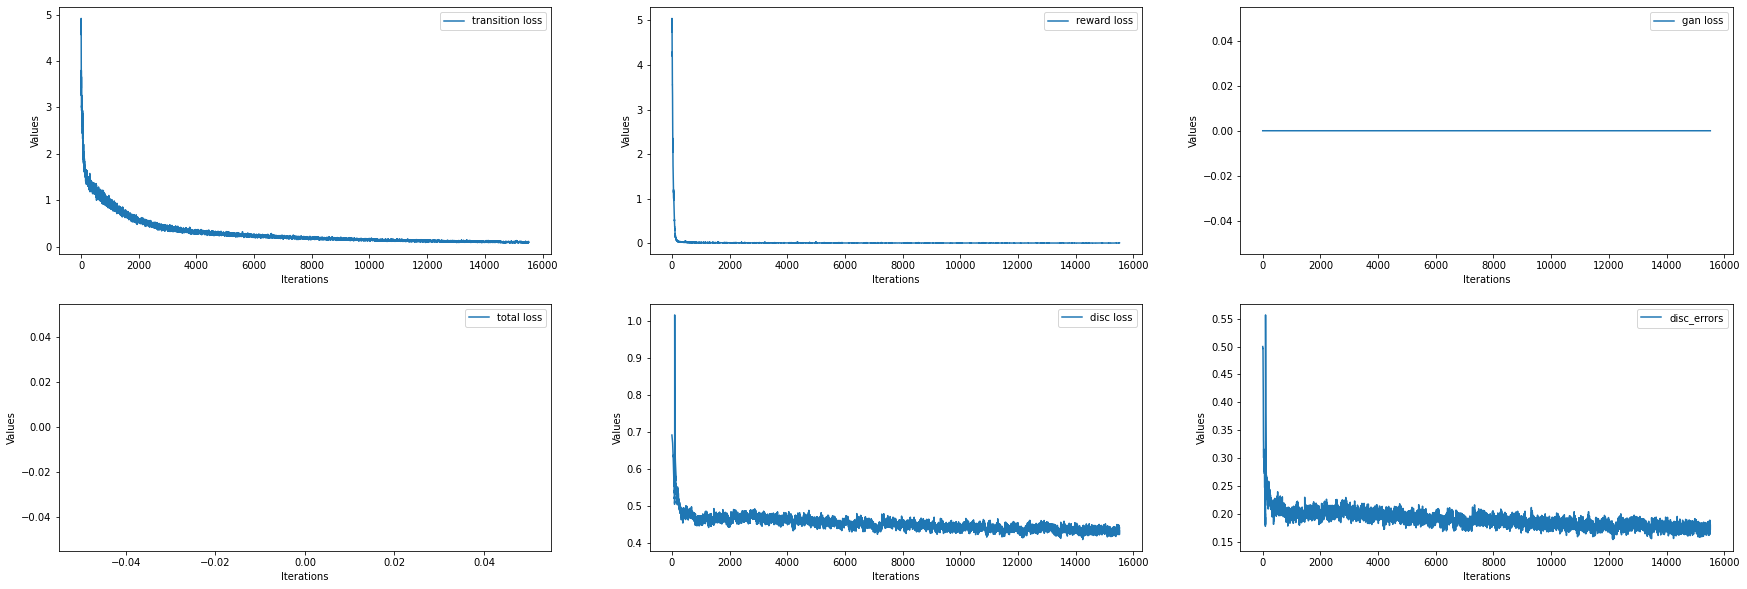

In [10]:
data_size = training_range[1] - training_range[0]

print('data_size:', data_size)

losses = {}
losses['transition'] = []
losses['reward'] = []
losses['gan'] = []
losses['total'] = []
losses['disc'] = []
losses['disc_errors'] = []

#shuffled_samples = range_shuffle_sample(replay_buffer._buffer, training_range[0], training_range[1])
#model_agent.set_data_statistics(shuffled_samples['state'], shuffled_samples['action'], shuffled_samples['next_state'])

for epoch in range(n_epoch):
    print('epoch:', epoch)
    
    shuffled_samples = range_shuffle_sample(replay_buffer._buffer, training_range[0], training_range[1])
    
    disc_errors, disc_losses = train_disc(shuffled_samples, model_agent, disc_agent, d_optim)
    losses['disc_errors'].extend(disc_errors)
    losses['disc'].extend(disc_losses)
    print('disc_losses:', disc_losses[-1])
    
    #gan_losses = gan_model(shuffled_samples, model_agent, disc_agent, g_optim)
    #losses['gan'].extend(gan_losses)
    #print('gan_losses:', gan_losses[-1])
    
    transition_losses, reward_losses, gan_losses = train_model(shuffled_samples, model_agent, disc_agent, t_optim, r_optim)
    losses['transition'].extend(transition_losses)
    losses['reward'].extend(reward_losses)
    losses['gan'].extend(gan_losses)
    print('transition_losses:', transition_losses[-1])
    
plot_losses(losses)



# 4. Training Plot

In [11]:
#plt.plot(losses['total'], label='total')
def plot_loss(losses):

    def subplot_setting(ax):
        ax.legend()
        ax.set_ylabel('Values')
        ax.set_xlabel('Iterations')

    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(30,10))
    ax[0][0].plot(losses['transition'], label='transition loss')
    ax[0][1].plot(losses['reward'], label='reward loss')
    ax[0][2].plot(losses['gan'], label='gan loss')
    ax[1][0].plot(losses['total'], label='total loss')
    ax[1][1].plot(losses['disc'], label='disc loss')
    ax[1][2].plot(losses['disc_errors'], label='disc_errors')

    subplot_setting(ax[0][0])
    subplot_setting(ax[0][1])
    subplot_setting(ax[0][2])
    subplot_setting(ax[1][0])
    subplot_setting(ax[1][1])
    subplot_setting(ax[1][2])

    plt.show()

In [12]:
def draw_plot(ax, title, ground_truth, prediction):    
    """    
    ax: subplot object
    title: string    
    ground_truth: (n, 1)    
    prediction: (n, 1)    
    """    
    gt = ground_truth.flatten()    
    pred = prediction.flatten()    

    sorted_indices = gt.view(-1).sort().indices    
    ax.plot(pred[sorted_indices].detach().cpu().numpy(), 'ro', markersize=1, label='Prediction')    
    ax.plot(gt[sorted_indices].detach().cpu().numpy(), 'bo', markersize=0.3, label='Ground Truth')    
    ax.legend(loc='upper left')    
    errors = pred - gt    
    ax.text(0.65, 0.20, 'MSE: {:.2e}'.format(errors.square().mean()), transform=ax.transAxes)                                                                                             
    ax.text(0.65, 0.15, 'MSE STD: {:.2e}'.format(errors.std()), transform=ax.transAxes)                                                                                                   
    ax.set_xlabel('Samples Sorted by Ground Truth Value')                                                                                                                
    ax.set_ylabel('Values')                                                                                                                                              
    ax.set_title(title)
    #ax.set_facecolor('xkcd:grey')
    #plt.savefig(".png"))                                                                                                            
    #plt.clf()

In [13]:
training_range
training = {}
training['state'] = replay_buffer._buffer['state'][training_range[0]:training_range[1], :]
training['action'] = replay_buffer._buffer['action'][training_range[0]:training_range[1], :]
training['reward'] = replay_buffer._buffer['reward'][training_range[0]:training_range[1], :]
training['next_state'] = replay_buffer._buffer['next_state'][training_range[0]:training_range[1], :]
#training['prev_state'] = replay_buffer._buffer['prev_state'][training_range[0]:training_range[1], :]
#training['prev_action'] = replay_buffer._buffer['prev_action'][training_range[0]:training_range[1], :]

In [14]:
#normalized_state, normalized_action, normalized_next_state = model_agent.preprocess(training['state'],  training['action'], training['next_state'])
#normalized_next_state, normalized_action = model_agent.preprocess(training['next_state'],  training['action'])
#next_state_diff = model_agent.transition(training['state'], training['action'])
next_state_diff, _ = model_agent.transition(training['state'], training['action'], ret_logvar=True)
#next_state_diff, _ = model_agent.transition(training['state'], training['state']-training['prev_state'], training['action'], training['prev_action'], ret_logvar=True)
next_state_pred = training['state'] + next_state_diff
#next_state_pred = model_agent.postprocess(next_state_pred)
reward_pred = model_agent.reward(training['state'], training['action'], next_state_pred.detach())

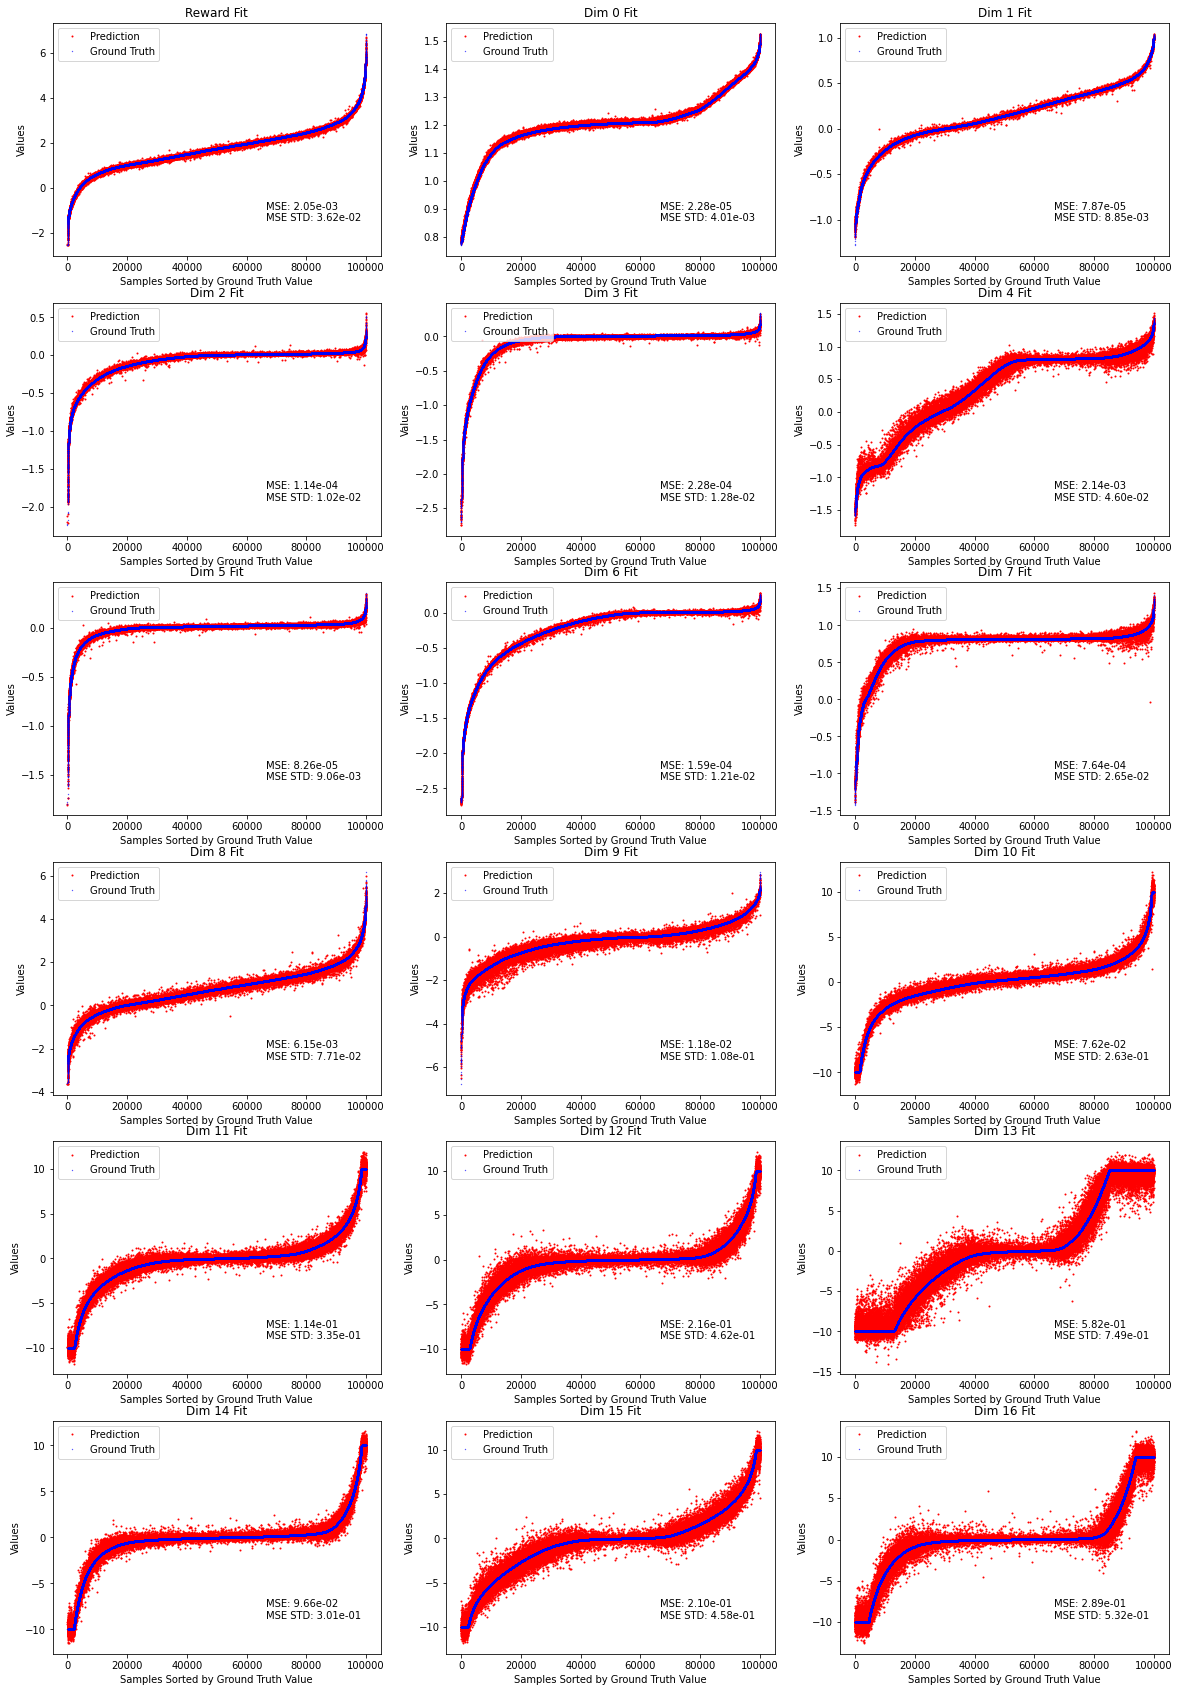

In [15]:
fig, ax = plt.subplots(nrows=6, ncols=3, figsize=(20,30))
for i in range(6):
    for j in range(3):
        plot_count =  3 * i + j
        if plot_count == 0:
            draw_plot(ax[i][j], "Reward Fit", training['reward'], reward_pred)
        elif plot_count > BufferFields['state']:
            continue
        else:
            dim = plot_count - 1
            draw_plot(ax[i][j], "Dim {} Fit".format(dim), training['next_state'][:,dim], next_state_pred[:, dim])
            #draw_plot(ax[i][j], "Dim {} Fit".format(dim), normalized_next_state[:,dim], next_state_pred[:, dim])
fig.patch.set_facecolor('white')
plt.savefig("fig.png")

# 5. Validation Plot

In [16]:
#validation_range = (int(90e3), int(100e3))
#validation_range = (int(100e3), int(110e3))
validation_range = (int(900e3), int(910e3))
validation = {}
validation['state'] = replay_buffer._buffer['state'][validation_range[0]:validation_range[1], :]
validation['action'] = replay_buffer._buffer['action'][validation_range[0]:validation_range[1], :]
validation['reward'] = replay_buffer._buffer['reward'][validation_range[0]:validation_range[1], :]
validation['next_state'] = replay_buffer._buffer['next_state'][validation_range[0]:validation_range[1], :]
#validation['prev_state'] = replay_buffer._buffer['prev_state'][validation_range[0]:validation_range[1], :]
#validation['prev_action'] = replay_buffer._buffer['prev_action'][validation_range[0]:validation_range[1], :]

In [17]:
next_state_diff = model_agent.transition(validation['state'], validation['action'])
#next_state_diff = model_agent.transition(validation['state'], validation['state']-validation['prev_state'], validation['action'], validation['prev_action'])
next_state_pred = validation['state'] + next_state_diff
reward_pred = model_agent.reward(validation['state'], validation['action'], next_state_pred.detach())

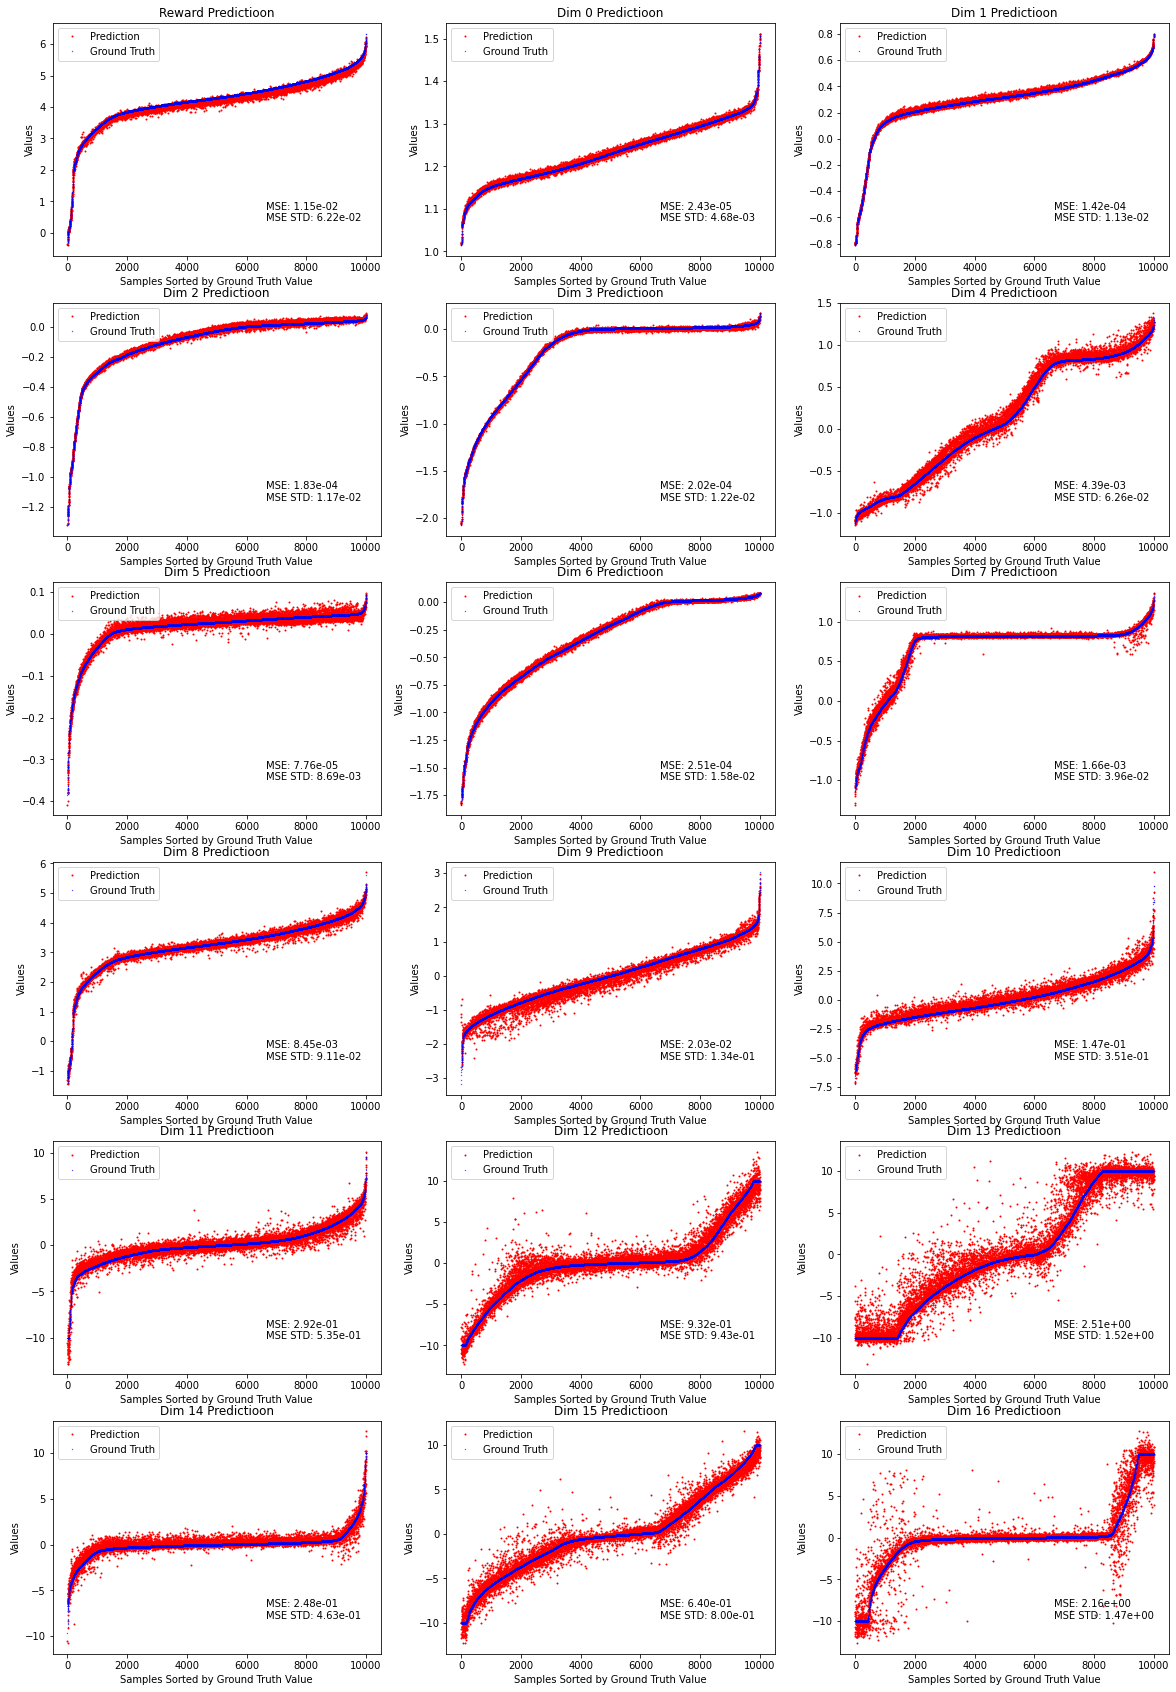

In [18]:
fig, ax = plt.subplots(nrows=6, ncols=3, figsize=(20,30))
for i in range(6):
    for j in range(3):
        plot_count =  3 * i + j
        if plot_count == 0: 
            draw_plot(ax[i][j], "Reward Predictioon", validation['reward'], reward_pred)
        elif plot_count > BufferFields['state']:
            continue
        else:
            dim = plot_count - 1
            draw_plot(ax[i][j], "Dim {} Predictioon".format(dim), validation['next_state'][:,dim], next_state_pred[:, dim])
fig.patch.set_facecolor('white')
plt.savefig("fig.png")